In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import sys
sys.path.append(os.path.join(Path(os.getcwd()).parents[0], "functions"))
import warnings
warnings.filterwarnings('ignore')
import helper_functions as hfn
import AIC_functions as aicfn
import plotting_functions as plotfn

In [2]:
# load models from lmfit package
from lmfit import Model
from lmfit.models import PowerLawModel
from lmfit.models import LognormalModel
from lmfit.models import ExponentialModel
from lmfit.models import LinearModel
from lmfit.models import QuadraticModel

In [3]:
def growth(x, i_max, ks):
    # x = starter number
    # we fit y = input number
    return i_max * x / (ks + x)

def hill(x, i_max, ks,n):
    return i_max / (1 + (ks/x)**n)

In [4]:
# create lmfit models for fits
model_pl = PowerLawModel()
model_exp = Model(aicfn.expfunc)
model_ln = LognormalModel()
model_lm = LinearModel()
model_quad = QuadraticModel()
gmodel = Model(growth)
hmodel = Model(hill)

In [5]:
path = Path(os.getcwd()).parents[0]

alldatapath = os.path.join(path, 'data')
datapath = os.path.join(alldatapath, 'clean')

figpath = os.path.join(path, 'figures')
hfn.dir_check(figpath)

In [6]:
fig1path = os.path.join(figpath, 'Fig1')
hfn.dir_check(fig1path)

In [7]:
fig1panelpaths = os.path.join(fig1path, 'panels')
hfn.dir_check(fig1panelpaths)

# set plotting params

In [8]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", 'coral']
sns.set_palette = sns.xkcd_palette(colors)
sns.set_style("ticks")
hfont = {'fontname':'Myriad Pro'}

# Load data

In [9]:
areas, areas_with_pre, df_raw, df_all, df_v1, df_pm = hfn.import_main_dataset(datapath)

In [10]:
df_log_all = hfn.make_log_df_full(df_all, areas)

### fit untransformed data

In [11]:
## linear fit
pars_lm = model_lm.guess(df_all['input'].values, x = df_all['starter'].values)
result_lm = model_lm.fit(df_all['input'].values, pars_lm, x = df_all['starter'].values)

In [12]:
## quadratic fit
pars_quad = model_quad.guess(df_all['input'].values, x = df_all['starter'].values)
result_quad = model_quad.fit(df_all['input'].values, pars_quad, x = df_all['starter'].values)

In [13]:
## power-law fit
pars_pl = model_pl.guess(df_all['input'].values, x = df_all['starter'].values)
result_pl = model_pl.fit(df_all['input'].values, pars_pl, x = df_all['starter'].values)

In [14]:
## exponential fit
pars_exp = model_exp.make_params(a = 1000, b = -500)
result_exp = model_exp.fit(df_all['input'].values, pars_exp, x = df_all['starter'].values)

In [15]:
## log-normal fit
pars_ln = model_ln.guess(df_all['input'].values, x = df_all['starter'].values)
pars_ln['amplitude'].set(6000, vary = True)
pars_ln['sigma'].set(5, vary = True)
pars_ln['center'].set(18, vary = True)
result_ln = model_ln.fit(df_all['input'].values, pars_ln, x = df_all['starter'].values)

In [16]:
# growth fit
datax = df_all['starter'].values
pars_g = gmodel.make_params(i_max = np.max(df_all['input'].values), ks =  datax[hfn.find_nearest(df_all['input'].values, np.max(df_all['input'].values)/2)[0]])

result_growth = gmodel.fit(df_all['input'].values, pars_g, x = df_all['starter'].values)

In [17]:
# # hill fit
# parsh = hmodel.make_params(i_max = np.max(df_all['input'].values), ks = datax[hfn.find_nearest(df_all['input'].values, np.max(df_all['input'].values)/2)[0]], n = 0.2)
# result_hill = hmodel.fit(df_all['input'].values, parsh, x = df_all['starter'].values)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


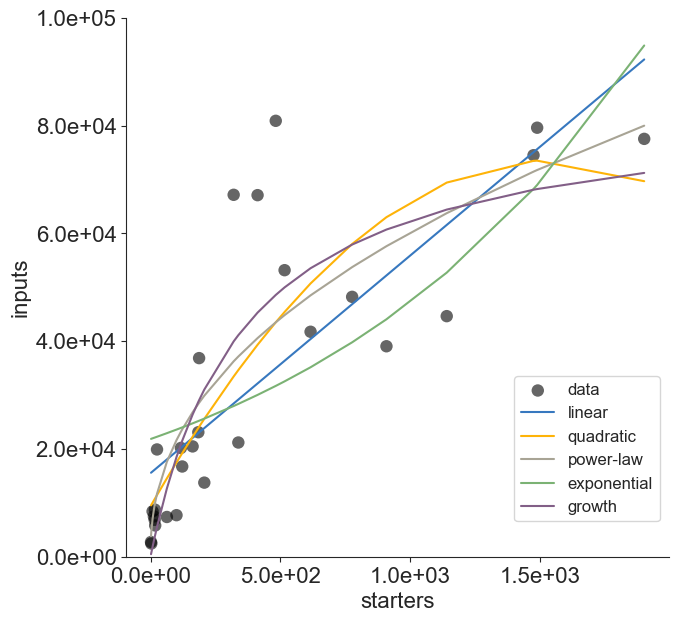

In [18]:
# Panel 1A : fit data in natural scale
list_fits_ln = [result_lm.best_fit, result_quad.best_fit, result_pl.best_fit, result_exp.best_fit,  result_growth.best_fit] #result_ln.best_fit,
fit_type = ['linear', 'quadratic', 'power-law', 'exponential', 'growth'] # , 'log-normal'

f1a = plt.figure(figsize= (7,7))

ax = f1a.add_subplot(111)
ax.tick_params(labelsize=16)

plt.scatter(df_all['starter'].values,df_all['input'].values, label='data', color = 'k', alpha = 0.6, s= 80, edgecolors='none')

for i, fit in enumerate(list_fits_ln):
    plt.plot(df_all['starter'].values, fit, color=sns.xkcd_palette(colors)[i], label = fit_type[i])

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.locator_params(axis='x', nbins=7)
plt.ylim((0,100000))
plt.xlabel('starters',fontsize = 16)
plt.ylabel('inputs',fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(0.7, 0.05))
plt.savefig(os.path.join(fig1panelpaths, 'fig1a.png'),  bbox_inches='tight')
plt.savefig(os.path.join(fig1panelpaths, 'fig1a.eps'),  bbox_inches='tight', format = 'eps')

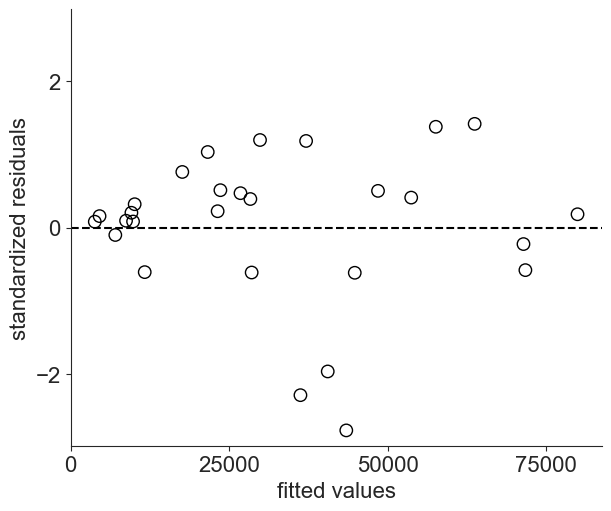

In [19]:
# Panel 1B: residuals vs fitted plot
f1b = plt.figure(figsize = (6, 5), constrained_layout=True)
ax = plt.gca()

plt.scatter(result_pl.best_fit, result_pl.residual/np.std(result_pl.residual),  facecolors='none', s= 80, edgecolors = 'k')
x1, x2 = ax.get_xlim()
plt.axhline(y=0, xmin=0, xmax=x2, ls='--', c = 'k')
max_ax = max(np.abs(ax.get_ylim()))
plt.ylim((-max_ax, max_ax))
# ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.locator_params(nbins=4)
plt.ylabel('standardized residuals',fontsize = 16)
plt.xlabel('fitted values',fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

plt.savefig(os.path.join(fig1panelpaths, 'fig1b.png'),  bbox_inches='tight')
plt.savefig(os.path.join(fig1panelpaths, 'fig1b.eps'),  bbox_inches='tight', format = 'eps')

## fit log-transformed data

In [20]:
## linear fit
pars_log_lm = model_lm.guess(df_log_all['input'].values, x = df_log_all['starter'].values)
result_log_lm = model_lm.fit(df_log_all['input'].values, pars_log_lm, x = df_log_all['starter'].values)

In [21]:
## quadratic fit
pars_log_quad = model_quad.guess(df_log_all['input'].values, x = df_log_all['starter'].values)
result_log_quad = model_quad.fit(df_log_all['input'].values, pars_log_quad, x = df_log_all['starter'].values)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


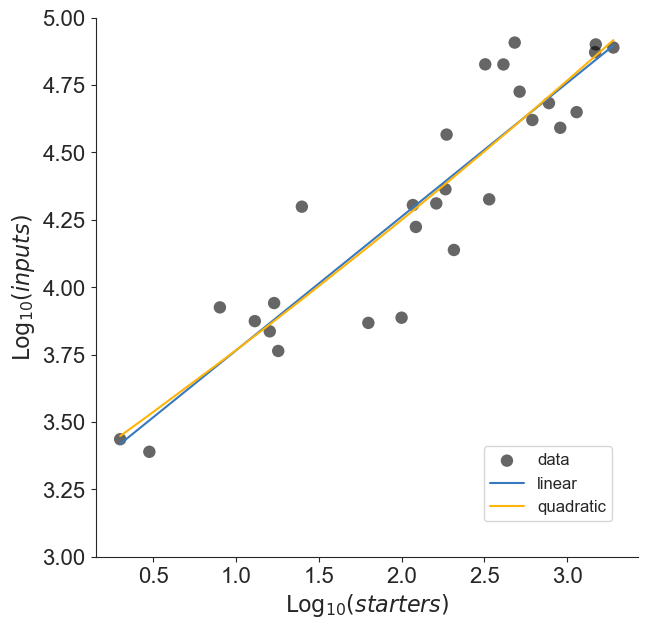

In [22]:
## Panel 1C : fit data in log scale

list_fits_ln = [result_log_lm.best_fit, result_log_quad.best_fit]
fit_type = ['linear', 'quadratic']

f1c = plt.figure(figsize= (7,7))

ax = f1c.add_subplot(111)
ax.tick_params(labelsize=16)

plt.scatter(df_log_all['starter'].values,df_log_all['input'].values, label='data', color = 'k', alpha = 0.6, s= 80, edgecolors='none')

for i, fit in enumerate(list_fits_ln):
    plt.plot(df_log_all['starter'].values, fit, color=sns.xkcd_palette(colors)[i], label = fit_type[i])


plt.locator_params(axis='x', nbins=7)
plt.ylim((3,5))
plt.xlabel(r'$\mathrm{Log}_{10}(starters)$',fontsize = 16)
plt.ylabel(r'$\mathrm{Log}_{10}(inputs)$',fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(fontsize=12, loc='lower left', bbox_to_anchor=(0.7, 0.05))
plt.savefig(os.path.join(fig1panelpaths, 'fig1c.png'),  bbox_inches='tight')
plt.savefig(os.path.join(fig1panelpaths, 'fig1c.eps'),  bbox_inches='tight', format = 'eps')

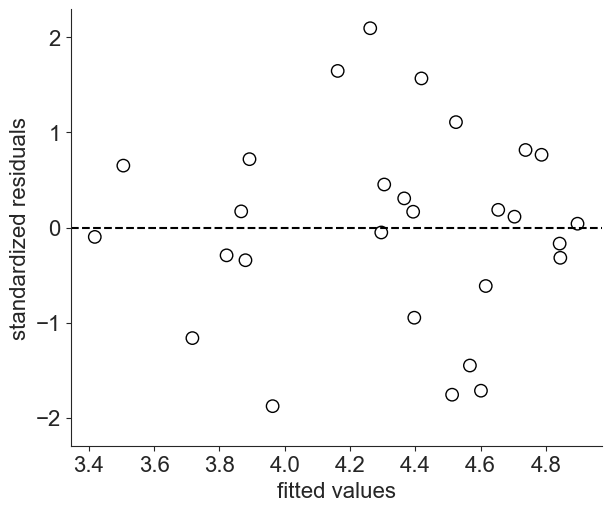

In [23]:
# Panel 1D: residuals vs fitted plot
f1d = plt.figure(figsize = (6, 5), constrained_layout=True)
ax = plt.gca()

plt.scatter(result_log_lm.best_fit, result_log_lm.residual/np.std(result_log_lm.residual),  facecolors='none', s= 80, edgecolors='k')
x1, x2 = ax.get_xlim()
plt.axhline(y=0, xmin=0, xmax=x2, ls='--', c = 'k')
max_ax = max(np.abs(ax.get_ylim()))
plt.ylim((-max_ax, max_ax))

plt.ylabel('standardized residuals',fontsize = 16)
plt.xlabel('fitted values',fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

plt.savefig(os.path.join(fig1panelpaths, 'fig1d.png'),  bbox_inches='tight')
plt.savefig(os.path.join(fig1panelpaths, 'fig1d.eps'),  bbox_inches='tight', format = 'eps')